# This notebook will be implementing the following task:

### Create a predictor on stock whether the next day's high value will be > 0.05 (5%) than it's opening price.

The simple idea: If we can predict with >= 50% accuracy whether a stock price will rise at least 5% above it's opening price, then we can compute the probability, given a "YES" with this model, will it rise at least 0.02 (2%) above it's opening price at some point during the day.

Letting mu represent the mean of the difference of the next day's high price and opening price over all the data and mu_yes be the same mean difference over the data the model predicts a "YES" for at least a 5% boost, I hope to see a statistically significant improvement of mu_yes over mu.
    
To build the model, the data obtained is from the stocks priced $10-$50 per share over the course of the past year in the fields of biotech, pharma, entertainment, and various technologies. To begin, we will import the data, which is previously cleaned, then make a function to create data that will be useful to analyze patterns, as the data imported is just the Date, Open, High, Low, Close, and Volume for that day.

The initial model we choose to use will be LogisiticRegression since it can output probabilities and coefficients, making it easily interpretable.

In [3]:
%config Completer.use_jedi = False

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
import scipy
from joblib import dump, load

In [5]:
df = pd.read_csv('HealthcareStockFeb2021.csv')

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,"Dec 11, 2020",61.00,71.91,48.98,58.90,9249200,ABCL
1,"Dec 14, 2020",56.93,60.69,50.00,50.01,1487300,ABCL
2,"Dec 15, 2020",50.81,52.21,45.26,46.99,3958000,ABCL
3,"Dec 16, 2020",47.13,49.73,42.15,47.53,1688700,ABCL
4,"Dec 17, 2020",48.54,50.50,48.14,48.60,636300,ABCL


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39987 entries, 0 to 39986
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    39987 non-null  object 
 1   Open    39987 non-null  float64
 2   High    39987 non-null  float64
 3   Low     39987 non-null  float64
 4   Close   39987 non-null  float64
 5   Volume  39987 non-null  int64  
 6   Ticker  39987 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 2.1+ MB


In [284]:
def HighLowVolatility(df):
    """
    Define High-Low Volatility as (High-Low)/High*100 (percentage)
    And add this column.
    """
    
    df['HighLowVolatility'] = 0 # Placeholder
    
    for i in range(len(df)):
        df.loc[i, 'HighLowVolatility'] = (df.loc[i, 'High'] - df.loc[i, 'Low'])/df.loc[i, 'High']
        
    return df

def HighOpenVolatility(df):
    """
    The difference of a day's high-open proportion.
    """
    
    df['HighOpenVolatility'] = (df['High'] - df['Open'])/df['Open']
        
    return df
        

def AvgHighLowVolatility(df, num_days=10):
    """
    Calculate the average HighLowVolatility for the past
    num_days days. Can specify num_days, which I will default to 10.
    """
    df[f'AvgHighLowVolatility_{num_days}'] = 0 # Placeholder
    
    for i in range(num_days, df.shape[0]):
        prev_high_low_vols = df.loc[i-num_days:i, 'HighLowVolatility']
        df.loc[i, f'AvgHighLowVolatility_{num_days}'] = prev_high_low_vols.mean()        
    return df

def AvgHighLowVolatilityRecursion(df, list_of_num_days):
    """
    Run AvgHighLowVolatility
    for all of the given days in list_of_num_days.
    """
    
    for num_days in list_of_num_days:
        df = AvgHighLowVolatility(df, num_days)
        
    return df


def NextDayHighMinusOpen(df):
    """
    Create column for the next day's highminusopen.
    Leave current day as 0.
    """
    
    df['NextDayHighMinusOpen'] = 0 # Placeholder
    
    for i in range(len(df)-1):
        df.loc[i, 'NextDayHighMinusOpen'] = df.loc[i+1, 'HighOpenVolatility']
        
    return df


def Target(df, threshold=0.03):
    """
    Binary target column depending on NextDayHighMinusOpen.
    I will default the threshold to 0.05
    """
    df['Target'] = 0 # Placeholder

    for i in range(df.shape[0]):
        curr = df.loc[i, 'NextDayHighMinusOpen']
        if curr >= threshold:
            df.loc[i, 'Target'] = 1
        else:
            df.loc[i, 'Target'] = 0
            
    return df
   

    
def RemoveZeroCols(df, list_of_num_days):
    """
    Remove the cols with zeros defaulted above.
    """
    zero_cols = ['NextDayHighMinusOpen']
    
    for num_days in list_of_num_days:
        zero_cols.append(f'AvgHighLowVolatility_{num_days}')

    zero_df = df[zero_cols]

    idx = []

    for i in range(zero_df.shape[0]):
        if True in zero_df.iloc[i].isin([0]).unique():
            idx.append(i)
            
    df = df.drop(idx, axis=0)    
    return df

# Compose the functions below
import functools


list_of_num_days = [3, 7, 10]

def add_columns(df):
    df = HighLowVolatility(df)
    df = HighOpenVolatility(df)
    df = AvgHighLowVolatilityRecursion(df, list_of_num_days)
    df = NextDayHighMinusOpen(df)
    df = Target(df)
    df = RemoveZeroCols(df, list_of_num_days)
    
    return df

In [285]:
# Apply the above change on a per-ticker basis

tickers = df['Ticker'].unique() # List of tickers
df_copy = df.copy()
final_df = pd.DataFrame(columns=df.columns) # Recreate new final df with new columns

for ticker in tickers:
    temp_df = df_copy[df_copy['Ticker']==ticker] # temp ticker
    temp_df.reset_index(inplace=True, drop=True)
    temp_df = add_columns(temp_df) # Transform
    final_df = final_df.append(temp_df)

final_df.reset_index(drop=True, inplace=True)

<ipython-input-284-97545996abbc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HighLowVolatility'] = 0 # Placeholder
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-284-97545996abbc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [286]:
final_df

,Date,Open,High,Low,Close,Volume,Ticker,HighLowVolatility,HighOpenVolatility,AvgHighLowVolatility_3,AvgHighLowVolatility_7,AvgHighLowVolatility_10,NextDayHighMinusOpen,Target
0,"Dec 28, 2020",42.65,42.96,38.30,40.55,1116800,ABCL,0.108473,0.007268,0.091731,0.088553,0.121505,0.008996,0.0
1,"Dec 29, 2020",41.13,41.50,38.00,39.00,1672000,ABCL,0.084337,0.008996,0.084528,0.080042,0.100183,0.065043,1.0
2,"Dec 30, 2020",38.59,41.10,37.62,41.10,851300,ABCL,0.084672,0.065043,0.087268,0.084784,0.091868,0.001206,0.0
3,"Dec 31, 2020",41.45,41.50,38.60,40.24,1201000,ABCL,0.069880,0.001206,0.086840,0.089403,0.086119,0.007500,0.0
4,"Jan 04, 2021",40.00,40.30,38.78,39.10,1121800,ABCL,0.037717,0.007500,0.069151,0.080441,0.075691,0.017779,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36154,"Feb 19, 2021",19.82,19.82,17.47,17.91,795200,ENLV,0.118567,0.000000,0.083022,0.114912,0.131910,0.018733,0.0
36155,"Feb 22, 2021",18.15,18.49,15.84,16.10,793300,ENLV,0.143321,0.018733,0.100947,0.101668,0.139426,0.034414,1.0
36156,"Feb 23, 2021",15.11,15.63,13.33,15.42,836400,ENLV,0.147153,0.034414,0.124520,0.104916,0.140746,0.068538,1.0
36157,"Feb 24, 2021",15.32,16.37,15.03,16.19,289900,ENLV,0.081857,0.068538,0.122724,0.101751,0.117421,0.038903,1.0


In [92]:
final_df.to_csv('FinalHealthCareDFTarget3.csv', index=False)

In [93]:
final_df = pd.read_csv('FinalhealthCareDFTarget3.csv')


In [287]:
final_df['Target'].value_counts()

0.0    20778
1.0    15381
Name: Target, dtype: int64

In [288]:
final_df.corr()['Target'].sort_values(ascending=False)

Target                     1.000000
NextDayHighMinusOpen       0.397627
AvgHighLowVolatility_7     0.285818
AvgHighLowVolatility_3     0.282805
AvgHighLowVolatility_10    0.280269
HighLowVolatility          0.243508
HighOpenVolatility         0.099114
High                      -0.111613
Close                     -0.119227
Open                      -0.119499
Low                       -0.126450
Name: Target, dtype: float64

The above correlations show that th AvgHighLowVolatility, HighLowVolatility, and HighOpenVolatility should have the largest impact on our prediction.

In [289]:
def split_df(df):
    """
    Correctly split df into X and y sets.
    """
    X = df.drop(['NextDayHighMinusOpen', 'Target', 'Date', 'Ticker'], axis=1)
    y = df['Target']
    
    return X, y

In [290]:
X, y = split_df(final_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [291]:
y_train.value_counts()

0.0    18700
1.0    13843
Name: Target, dtype: int64

### Create and train logistic model

In [292]:
log = LogisticRegression()

lognet_param_grid = {'log__C': [0.0001],
                  'log__penalty': ['elasticnet'],
                  'log__solver': ['saga'],
                  'log__l1_ratio': [0.25],
                  'log__max_iter': [10000],
                 }

log_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log', log),
])

In [300]:
lognet_grid = GridSearchCV(estimator=log_pipe, param_grid=lognet_param_grid, cv=5, scoring='precision', verbose=2)

lognet_grid.fit(X, y)

lognet_grid.cv_results_['mean_test_score']

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END log__C=0.0001, log__l1_ratio=0.25, log__max_iter=10000, log__penalty=elasticnet, log__solver=saga; total time=   0.0s
[CV] END log__C=0.0001, log__l1_ratio=0.25, log__max_iter=10000, log__penalty=elasticnet, log__solver=saga; total time=   0.0s
[CV] END log__C=0.0001, log__l1_ratio=0.25, log__max_iter=10000, log__penalty=elasticnet, log__solver=saga; total time=   0.0s
[CV] END log__C=0.0001, log__l1_ratio=0.25, log__max_iter=10000, log__penalty=elasticnet, log__solver=saga; total time=   0.0s
[CV] END log__C=0.0001, log__l1_ratio=0.25, log__max_iter=10000, log__penalty=elasticnet, log__solver=saga; total time=   0.0s


array([0.75109598])

In [294]:
final_model = lognet_grid

In [308]:
dump(final_model, 'FinalStockModelHealth.joblib')

['FinalStockModelHealth.joblib']

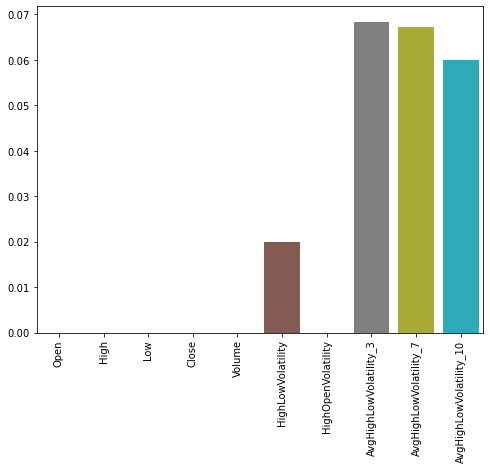

In [295]:
# Series for coefs

coefs = final_model.best_estimator_['log'].coef_[0]

coef_series = pd.Series(data=coefs, index=X.columns)

# Plot series

plt.figure(figsize=(8,6))

sns.barplot(x=coef_series.index, y=coef_series.values)

plt.xticks(rotation=90)

plt.show()

Unsurprisingly, our model above thinks that really, none of the data matters except the HighLowVolatility and the AvgHighLowVolatlity.

We can use this to improve on the model, by finding AvgHighLowVolatility for a different amount of days.

In [296]:
train_preds = final_model.predict(X_train)

print(classification_report(train_preds, y_train))

              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     30084
         1.0       0.13      0.73      0.22      2459

    accuracy                           0.61     32543
   macro avg       0.55      0.66      0.48     32543
weighted avg       0.90      0.61      0.70     32543



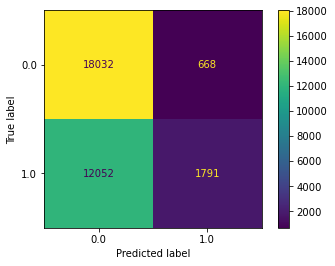

In [297]:
plot_confusion_matrix(final_model, X_train, y_train)

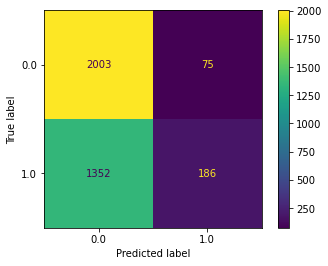

In [298]:
plot_confusion_matrix(final_model, X_test, y_test)

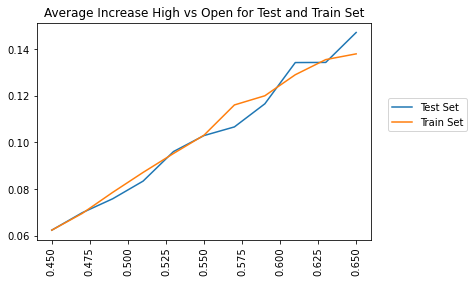

In [299]:
# Test avg gains given particular prob thresholds

### Gathering test set data for visual
preds_test = final_model.predict(X_test)
preds_prob_test = final_model.predict_proba(X_test)
preds_prob_yes_test = preds_prob_test[:,1]

prob_series_test = pd.Series(index=y_test.index, data=preds_prob_yes_test)

probs = np.arange(0.45, 0.66, 0.02)

prob_avgs_test = []
for prob in probs:
    prob_series_high_test = prob_series_test[prob_series_test > prob]

    idx = prob_series_high_test.index

    avg = final_df.iloc[idx]['NextDayHighMinusOpen'].mean()
    
    prob_avgs_test.append(avg)
    

prob_avg_series_test = pd.Series(index=probs, data=prob_avgs_test)


### Gathering training set data for visual
preds_train = final_model.predict(X_train)
preds_prob_train= final_model.predict_proba(X_train)
preds_prob_yes_train = preds_prob_train[:,1]

prob_series_train = pd.Series(index=y_train.index, data=preds_prob_yes_train)

probs = np.arange(0.45, 0.66, 0.02)

prob_avgs_train = []
for prob in probs:
    prob_series_high_train = prob_series_train[prob_series_train > prob]

    idx = prob_series_high_train.index

    avg = final_df.iloc[idx]['NextDayHighMinusOpen'].mean()
    
    prob_avgs_train.append(avg)
    

prob_avg_series_train = pd.Series(index=probs, data=prob_avgs_train)

sns.lineplot(x=prob_avg_series_test.index, y=prob_avg_series_test.values, markers=True, label='Test Set')
sns.lineplot(x=prob_avg_series_test.index, y=prob_avg_series_train.values, markers=True, label='Train Set')

plt.legend(loc=(1.05, 0.5))
plt.title("Average Increase High vs Open for Test and Train Set")
plt.xticks(rotation=90)

plt.show()

### The visual above shows that, if our model predicts at least a 55% of a yes, we can expect about a 13% increase

I will retrain the model on the entirety of X and y, create the same visual below, then run a simple Ttest to determine statistical significance.

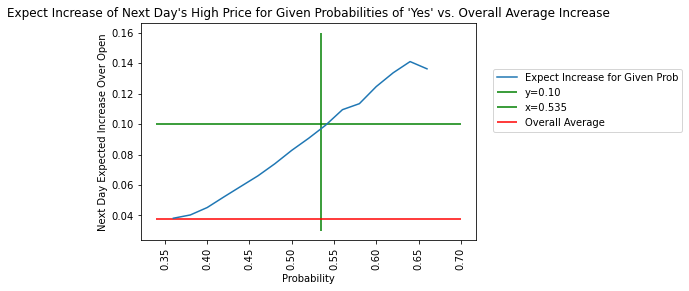

In [301]:
### Gathering data for final visual

preds = final_model.predict(X)
preds_prob= final_model.predict_proba(X)
preds_prob_yes = preds_prob[:,1]

prob_series = pd.Series(index=y.index, data=preds_prob_yes)

probs = np.arange(0.36, 0.66, 0.02)

prob_avgs = []
for prob in probs:
    prob_series_high = prob_series[prob_series > prob]

    idx = prob_series_high.index

    avg = final_df.iloc[idx]['NextDayHighMinusOpen'].mean()
    
    prob_avgs.append(avg)
    

prob_avg_series = pd.Series(index=probs, data=prob_avgs)
sns.lineplot(x=prob_avg_series.index, y=prob_avg_series.values, markers=True, label='Expect Increase for Given Prob')

plt.xticks(rotation=90)
plt.hlines(0.10, xmin=0.34, xmax=0.7, color='green', label='y=0.10')
plt.vlines(0.535, ymin=0.03, ymax=0.16, color='green', label='x=0.535')

plt.xlabel('Probability')
plt.ylabel('Next Day Expected Increase Over Open')

prob_overall = final_df['NextDayHighMinusOpen'].mean()

plt.hlines(prob_overall, xmin=0.34, xmax=0.7, label='Overall Average', color='red')

plt.title("Expect Increase of Next Day's High Price for Given Probabilities of 'Yes' vs. Overall Average Increase")
plt.legend(loc=(1.05, 0.5))
plt.show()

In [302]:
# The amount of data points that have the given condition above.
preds_prob_yes[preds_prob_yes > 0.535].shape

(1372,)

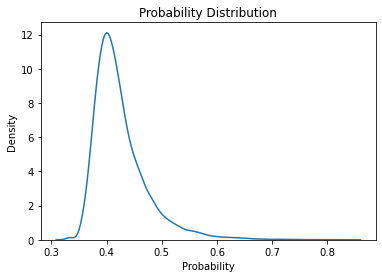

In [303]:
# Probability distribution Graph
sns.kdeplot(x=preds_prob_yes)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.show()

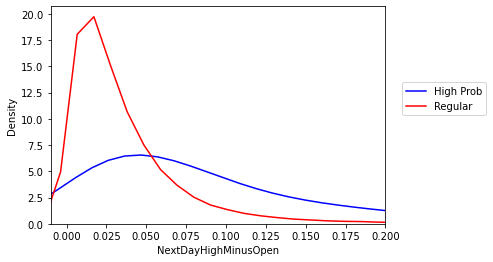

In [304]:
# Distribution of Having Probability > 0.535 vs Overall for Increase

prob_series # The series of probability of yes

prob_series_high = prob_series[prob_series > 0.535]

idx = prob_series_high.index

next_day_high_prob = final_df.iloc[idx]['NextDayHighMinusOpen']
next_day_no_outlier = final_df[final_df['NextDayHighMinusOpen'] < 3]['NextDayHighMinusOpen']

sns.kdeplot(x=next_day_high_prob, color='blue', label='High Prob')
sns.kdeplot(x=next_day_no_outlier, color='red', label='Regular')

plt.legend(loc=(1.05, 0.5))

plt.xlim(-0.01, 0.2)
plt.show()

The above distribution comparison shows that, picking a stock by random chance should have a much smaller growth, in general, than, picking one that has a high probability (at least 53.5%) of growing by at least 3%.

I will perform a Ttest to confirm this

In [305]:
sample = next_day_high_prob
n = len(sample)

sample.mean()

0.0965859136441469

In [306]:
pop = next_day_no_outlier
N = len(pop)

pop.mean()

0.037478592235920746

In [307]:
ttest_results = scipy.stats.ttest_1samp(sample, pop.mean())

statistic, pvalue = ttest_results

print("A one sample T-test comparing the avg from the population (entire test set) to" + 
      "the sample of 'YES' from the model on the test set gives:" + "\n\n\t" + 
      f"Statistic: {statistic}" + "\n\t" + f"p-value: {pvalue}.")

A one sample T-test comparing the avg from the population (entire test set) tothe sample of 'YES' from the model on the test set gives:

	Statistic: 17.712528705117723
	p-value: 2.2333399068713031e-63.


The above p-value <<< 0.05, so our results are statistically significant, showing that, when the model predicts "YES" on the next day's high minus open price for a given stock to be >0.05 (5%), there is a statistically significant difference between the expected value of a "YES" vs the expected value of any random stock.